# Imports

In [1]:
from modules.data import data_loader, data_splitter, data_reader
from modules.models import arima, lag_llama, autoregressor
from modules.evaluation import evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from modules.experiment.experiment import run_experiment
from modules.data.tscv import create_tscv_dataset
from modules.experiment.tscv import get_tscv_results, mean_directional_accuracy, get_summary


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Parameters

In [2]:
PREDICTION_LENGTH = 5 # currentlz only works for PREDICTION_LENGTH > 1
FREQUENCY = "daily" # currently we only have dailz frequency
TYPE_OF_DATA = "stock" # currently we only have stock prices saved
MODELS = ["arima", "llama"] # currentlz works onlz for these two
FOLDS = 5 # for TSCV
CONTEXT_LENGTH = 64

#START_DATE = 
#END_DATE
# want to add
#TRAIN_PERIOD = # context lenghts. Should take a look into this
#TRAIN_SIZE = 




# Notes

 - autoregressor
 - mean directional accuracy
 - ask
 - for each time-series create a whole dataframe for TSCV
  - problem with this is with time horizon that is >1 
  - prediction horizon is only for that value in the future

# TO DO

 - create the TSCV experiment. It needs to create a table. Metrics for each fold
 - lit review
 - content for the presentation by monday!!
 - review data leakage risk
 - writing of the dissertation
 - autoregressor
 - MDA metric
 - frequency

 Writing
 - lit review
 - lit reading

# Loading the data

In [3]:
data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY)
# this is just in case there are more CSVs of the same type and frequency, the data should be the first in the list
#if len(data) > 1:
data = data[0]

simple_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, simple = True)
#if len(simple_data) > 1:
simple_data = simple_data[0]

# Prepare the data

In [4]:
# pass full data at maximum granularity and produce according to frequency parameter

In [6]:
#tscv_data = create_tscv_dataset(data = simple_data, context_length=CONTEXT_LENGTH, n_folds=FOLDS, prediction_horizon=PREDICTION_LENGTH, max_folds=False)

# Models

In [7]:
# arima


In [8]:
# lag llama

# SKLearn TSCV

In [4]:
r, p, a = get_tscv_results(simple_data, PREDICTION_LENGTH, CONTEXT_LENGTH, FOLDS, frequency=FREQUENCY)

Fold 1/5 finished in: 4.41 seconds
Prediction from   2024-06-03   until   2024-06-07
----------------------
Fold 2/5 finished in: 6.08 seconds
Prediction from   2024-06-10   until   2024-06-14
----------------------
Fold 3/5 finished in: 5.93 seconds
Prediction from   2024-06-17   until   2024-06-24
----------------------
Fold 4/5 finished in: 5.61 seconds
Prediction from   2024-06-25   until   2024-07-01
----------------------
Fold 5/5 finished in: 5.87 seconds
Prediction from   2024-07-02   until   2024-07-09
----------------------


In [5]:
#creating the summary for each model
s = [get_summary(r[i]) for i in range(len(r))]

In [15]:
# breaking down the results by mean, median and std
def extract_metrics(dataframes):
    means = pd.DataFrame()
    medians = pd.DataFrame()
    stds = pd.DataFrame()
    
    for idx, df in enumerate(dataframes):
        means = pd.concat([means, df.loc['mean'].to_frame().T], ignore_index=True)
        medians = pd.concat([medians, df.loc['median'].to_frame().T], ignore_index=True)
        stds = pd.concat([stds, df.loc['std'].to_frame().T], ignore_index=True)
    
    means.index = ["arima", "lag_llama", "autoregressor"]
    medians.index = ["arima", "lag_llama", "autoregressor"]
    stds.index = ["arima", "lag_llama", "autoregressor"]
    
    return means, medians, stds


means_df, medians_df, stds_df = extract_metrics(s)

In [17]:
means_df

,r2,mse,mae,rmse,mda,mape
arima,-3.357645,60.446338,6.226377,6.777349,0.40,0.029166
lag_llama,-146.245641,1329.970883,34.055083,34.802063,0.48,0.159576
autoregressor,-3.583332,63.216869,6.386801,6.937637,0.00,0.029900


# Visualisation

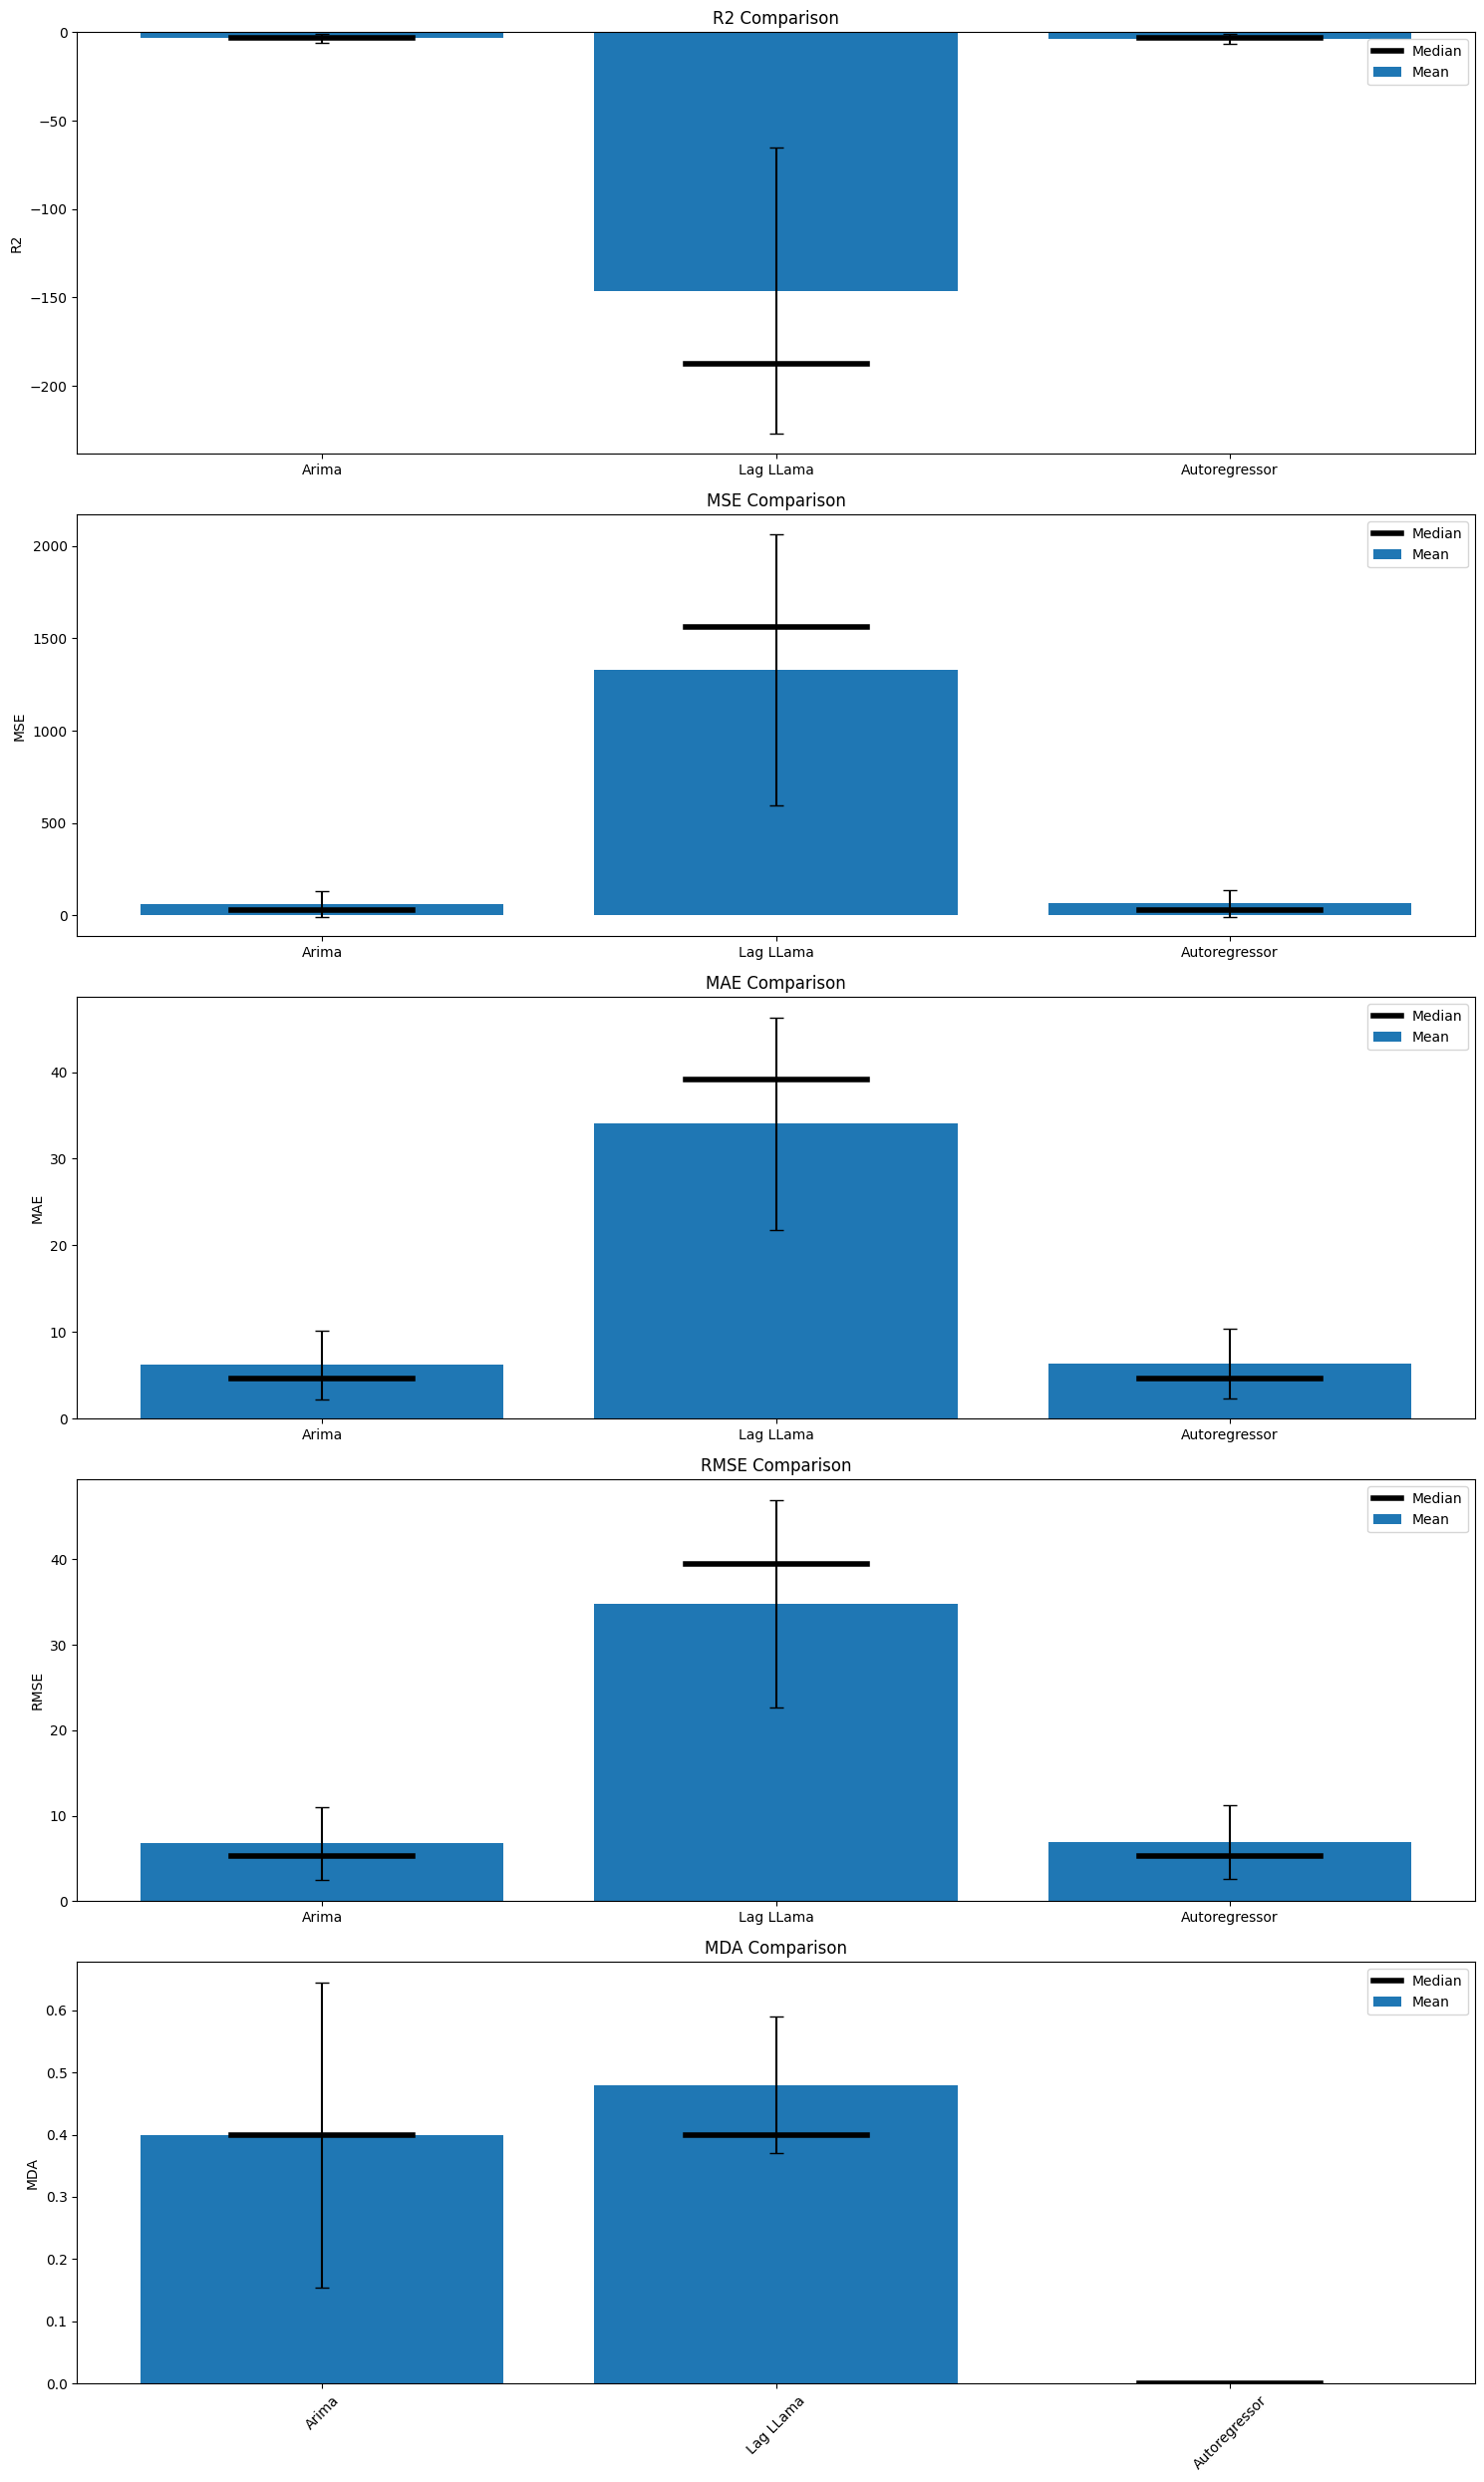

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'r' is your list of dataframes
# Sample structure for 'r'
# r = [df1, df2, df3, ...]

# Model names
model_names = ['Arima', 'Lag LLama', 'Autoregressor']

# Extracting summary statistics for each model
summary_stats = {'model': [], 'metric': [], 'mean': [], 'median': [], 'std': []}
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda']

for i, df in enumerate(s):
    for metric in metrics:
        summary_stats['model'].append(model_names[i])
        summary_stats['metric'].append(metric)
        summary_stats['mean'].append(df.loc['mean', metric])
        summary_stats['median'].append(df.loc['median', metric])
        summary_stats['std'].append(df.loc['std', metric])

summary_df = pd.DataFrame(summary_stats)

# Plotting
fig, axes = plt.subplots(len(metrics), 1, figsize=(15, len(metrics) * 5))

for idx, metric in enumerate(metrics):
    metric_data = summary_df[summary_df['metric'] == metric]
    
    # Plotting mean with error bars representing standard deviation
    axes[idx].bar(metric_data['model'], metric_data['mean'], yerr=metric_data['std'], capsize=5, label='Mean')
    
    # Plotting median as a thick black line
    for i, model in enumerate(metric_data['model']):
        median_value = metric_data[metric_data['model'] == model]['median'].values[0]
        axes[idx].plot([i - 0.2, i + 0.2], [median_value, median_value], color='black', linewidth=4, label='Median' if i == 0 else "")

    axes[idx].set_title(f'{metric.upper()} Comparison')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Model names
model_names = ['Arima', 'Lag LLama', 'Autoregressor']

# Extracting summary statistics for each model
summary_stats = {'model': [], 'metric': [], 'mean': [], 'median': [], 'std': []}
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda', "mape"]

for i, df in enumerate(s):
    for metric in metrics:
        summary_stats['model'].append(model_names[i])
        summary_stats['metric'].append(metric)
        summary_stats['mean'].append(df.loc['mean', metric])
        summary_stats['median'].append(df.loc['median', metric])
        summary_stats['std'].append(df.loc['std', metric])

summary_df = pd.DataFrame(summary_stats)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Model Metrics Comparison"),
    html.Div([
        html.Label('Select Metrics:'),
        dcc.Dropdown(
            id='metric-selector',
            options=[{'label': metric.upper(), 'value': metric} for metric in metrics],
            value=metrics,
            multi=True
        ),
        html.Label('Select Models:'),
        dcc.Dropdown(
            id='model-selector',
            options=[{'label': model, 'value': model} for model in model_names],
            value=model_names,
            multi=True
        )
    ], style={'width': '50%', 'display': 'inline-block'}),
    dcc.Graph(id='metric-graph')
])

@app.callback(
    Output('metric-graph', 'figure'),
    [Input('metric-selector', 'value'),
     Input('model-selector', 'value')]
)
def update_graph(selected_metrics, selected_models):
    fig = go.Figure()

    model_color_map = {
        'Arima': 'red',
        'Lag LLama': 'green',
        'Autoregressor': 'blue'
    }

    for metric in selected_metrics:
        for model in selected_models:
            metric_data = summary_df[(summary_df['model'] == model) & (summary_df['metric'] == metric)]
            color = model_color_map[model]

            fig.add_trace(go.Bar(
                x=[metric.upper()],
                y=metric_data['mean'],
                error_y=dict(type='data', array=metric_data['std'], visible=True),
                name=f'{model} Mean',
                hovertext=f'{model} - {metric.upper()}',
                hoverinfo='text+y',
                legendgroup=model,
                marker_color=color,
                offsetgroup=model
            ))

            # Adding median as a thick black line
            fig.add_trace(go.Scatter(
                x=[metric.upper()],
                y=metric_data['median'],
                mode='markers',
                marker=dict(color='black', size=10, symbol='line-ns-open'),
                name=f'{model} Median',
                hoverinfo='skip',
                legendgroup=model,
                showlegend=False,
                offsetgroup=model
            ))

    # Updating layout
    fig.update_layout(
        title='Model Metrics Comparison',
        barmode='group',
        xaxis=dict(title='Metrics', categoryorder='array', categoryarray=[metric.upper() for metric in selected_metrics]),
        yaxis=dict(title='Metric Value'),
        legend=dict(orientation='h', y=-0.2),
        height=500,
        width=800
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [10]:
def visualize_predictions(p, a):
    """
    Visualizes the predictions and actual values of the time series.

    Parameters:
    p (list of pd.DataFrame): List containing the dataframes for the models.
    a (pd.DataFrame): DataFrame containing the actual values.

    Returns:
    fig: Plotly figure object.
    """
    model_mapping = {
        "Arima": p[0],
        "Lag llama": p[1],
        "Autoregressor": p[2]
    }

    models = list(model_mapping.keys())
    folds = list(range(len(a)))

    fig = make_subplots(rows=1, cols=1)
    
    # Add traces for all models and folds, but make them invisible initially
    for model in models:
        for fold in folds:
            predicted_values = model_mapping[model].iloc[fold].values
            fig.add_trace(go.Scatter(x=list(range(1, len(predicted_values)+1)), 
                                     y=predicted_values, 
                                     mode='lines+markers', 
                                     name=f'{model} Fold {fold}',
                                     visible=False))
            
    for fold in folds:
        actual_values = a.iloc[fold].values
        fig.add_trace(go.Scatter(x=list(range(1, len(actual_values)+1)), 
                                 y=actual_values, 
                                 mode='lines+markers', 
                                 name=f'Actual Fold {fold}',
                                 visible=False))

    # Create buttons for folds
    fold_buttons = []
    for fold in folds:
        visibility = []
        for trace in fig.data:
            if f'Fold {fold}' in trace.name:
                visibility.append(True)
            else:
                visibility.append(False)
        button = dict(
            label=f'Fold {fold}',
            method='update',
            args=[{'visible': visibility},
                  {'title': f'Actual values and Model predictions for Fold {fold}'}]
        )
        fold_buttons.append(button)

    fig.update_layout(
        updatemenus=[
            dict(active=0,
                 buttons=fold_buttons,
                 direction='down',
                 showactive=True,
                 x=0.57,
                 xanchor="left",
                 y=1.17,
                 yanchor="top")
        ],
        title=f'Actual values and Model predictions for ',
        height=600,
        width=800,
        xaxis_title="Prediction Horizon",
        yaxis_title=f"{TYPE_OF_DATA} value"
    )
    
    # Initially show the first fold
    fig.update_traces(visible=True, selector=dict(name=f'Arima Fold 0'))
    fig.update_traces(visible=True, selector=dict(name=f'Lag llama Fold 0'))
    fig.update_traces(visible=True, selector=dict(name=f'Autoregressor Fold 0'))
    fig.update_traces(visible=True, selector=dict(name=f'Actual Fold 0'))

    return fig

# Example usage
fig = visualize_predictions(p, a)
fig.show()


LABEL the graph
label the axes with timestamps
show the history of the actual
table of comparison, not just graph

# Fine-tuning lag-llama

In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [5]:
ckpt_path = "modules/models/llama/ft-lag-llama.ckpt"

import torch

from lag_llama.gluon.estimator import LagLlamaEstimator

ckpt = torch.load(ckpt_path, map_location=torch.device("cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path=ckpt_path,
        prediction_length=PREDICTION_LENGTH,
        context_length=CONTEXT_LENGTH,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=10,
        num_parallel_samples=100,
        trainer_kwargs = {"max_epochs": 30,}, # <- lightning trainer arguments
    )

In [6]:
fine_tune_data = lag_llama.prepare_data(simple_data, 0, "daily")

In [7]:
predictor = estimator.train(fine_tune_data, cache_data = True, shuffle_buffer_length = 1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: c:\Users\topco\Dokumenti\MSc Banking and Digital Finance UCL\Modules\Dissertation\MSc_dissertation\lightning_logs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4.71682 (best 4.71682), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_0\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.59530 (best 3.59530), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_0\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.33410 (best 3.33410), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_0\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 3.11318 (best 3.11318), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Fina

In [9]:
fine_tune_test_data = lag_llama.prepare_data(simple_data, 5, "daily")

In [23]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=fine_tune_test_data,
        predictor=predictor,
        num_samples=100
    )

In [24]:
forecasts = list(tqdm(forecast_it, total=len(fine_tune_data), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
ft_lag_llama_forecast = forecasts[0].samples.mean(axis = 0)

In [37]:
ft_lag_llama_forecast

array([225.32787886, 224.87043645, 213.78376261, 202.3769921 ,
       216.41959789])

In [33]:
import yfinance as yf
import pandas as pd

ticker_symbol = 'AAPL'

# Define the date range
start_date = '2024-07-10'
end_date = '2024-07-17'

# Download the data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extract and display the Close prices
close_prices = data['Close']
print(close_prices)

[*********************100%%**********************]  1 of 1 completed
Date
2024-07-10    232.979996
2024-07-11    227.570007
2024-07-12    230.539993
2024-07-15    234.399994
2024-07-16    234.820007
Name: Close, dtype: float64


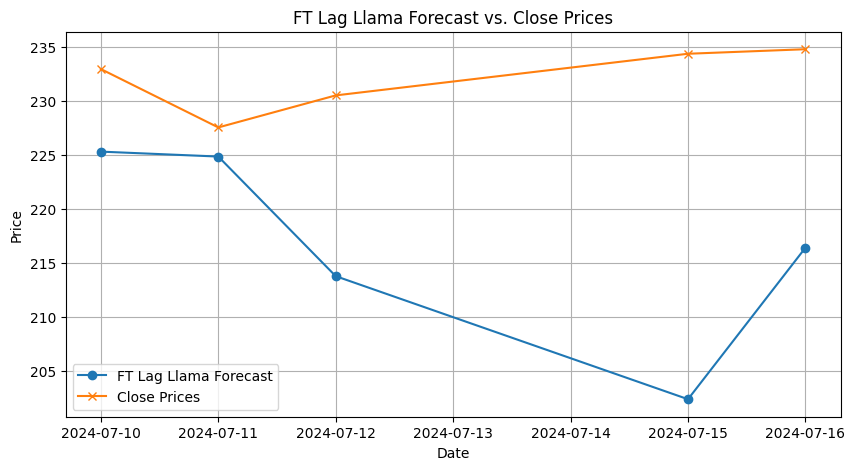

In [39]:
dates = pd.date_range(start='2024-07-10', end='2024-07-16', freq='B')

ft_lag_llama_forecast_series = pd.Series(ft_lag_llama_forecast, index=dates)
close_prices_series = pd.Series(close_prices, index=dates)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(ft_lag_llama_forecast_series, label='FT Lag Llama Forecast', marker='o')
plt.plot(close_prices_series, label='Close Prices', marker='x')

# Adding title and labels
plt.title('FT Lag Llama Forecast vs. Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()